### Проверка правильности работы загрузчика данных с аугментацией

In [1]:
import pandas as pd
import os
import glob
import cv2
import torch
from torchinfo import summary
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import math
from torch.optim.lr_scheduler import ExponentialLR
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix
from typing import Tuple
import sys
from sklearn.metrics import accuracy_score

from config import (
    verbose, 
    image_height, 
    image_width, 
    treashold,
    num_workers,
    train_df_path,
    test_weights
    )

from lib.wrapper import ModelWrapper
from lib.dataset import KeypointDataset
from lib.mobilenet import MobileKeypointNet
from lib.metrics import MeanRelativeDistance, MeanAccuracy

In [2]:
def visualize_batch(images: torch.Tensor, landmarks: torch.Tensor, size: int = 14, 
                    shape: tuple = (6, 6), title: str = None, save: bool = None):
    '''Функция проверки правильной работы пайплайна предобработки данных перед подачей в нейронную сеть
    (с учетом аугментации) на основе сформированного батча путем вывода на экран изображений, находящихся в батче,
    и соответствующих им ключевых точек
    Входные параметры:
    images: torch.Tensor - батч изображений
    landmarks: torch.Tensor - батч координат ключевых точек
    size: int - размер фигуры для отрисовки изображений и ключевых точек
    shape: tuple - число ячеек по горизонтали и вертикали, в которых будут изображения
    title: str - заголовок
    save: bool - флаг сохранения'''
    
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images, landmarks):
        landmarks = landmarks.view(-1, 2)
        landmarks = landmarks.numpy()
        image = torch.permute(image, (1, 2, 0))
        ax.imshow(image)
        ax.scatter(landmarks[0, 0], landmarks[0, 1], s = 10, c = 'red')
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

In [3]:
def visualize_errors(dataframe: pd.DataFrame, max_images: int, size: int, n_cols: int):
    '''Функция проверки правильности предсказанных моделью меток путем вывода на экран изображений,
    предсказанных меток и ground truth меток
    Входные параметры:
    dataframe: pd.DataFrame - таблица с информацией о локальных адресах изображений, координатах 
    ключевых точек, предсказанных координатах ключевых точек
    max_images: int - максимальное число выводимых изображений
    size: int - параметр размера выводимых изображений
    n_cols: int - количество колонок в сетке'''
    
    if(dataframe.shape[0]) > max_images:
        len_ = max_images
    else:
        len_ = dataframe.shape[0]
    dataframe = dataframe.head(len_)
        
    n_rows = math.ceil(len_/n_cols)
    shape = (n_rows, n_cols)
    fig = plt.figure(figsize = (size*n_cols, size*n_rows))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    
    image_paths = dataframe['image_paths']
    landmarks = dataframe['keypoints']
    pred_landmarks = dataframe['keypoints_pred']
    
    for ax, image_path, landmark, pred_landmark in zip(grid, image_paths, landmarks, pred_landmarks):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float')/255.0
        ax.scatter(landmark[0], landmark[1], s = 25, c = 'dodgerblue')
        ax.scatter(pred_landmark[0], pred_landmark[1], s = 25, c = 'red')
        ax.imshow(image)
        
    plt.show()

In [4]:
dataframe = pd.read_pickle(train_df_path)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, interpolation=1, border_mode=4, value=None, always_apply=True, p=1),
    ToTensorV2()], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False, angle_in_degrees=True))

dataset = KeypointDataset(
        dataframe, 
        transform, 
        image_height=image_height, 
        image_width=image_width)

data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=num_workers)
iterator = iter(data_loader)

Check Dataset and augmentation


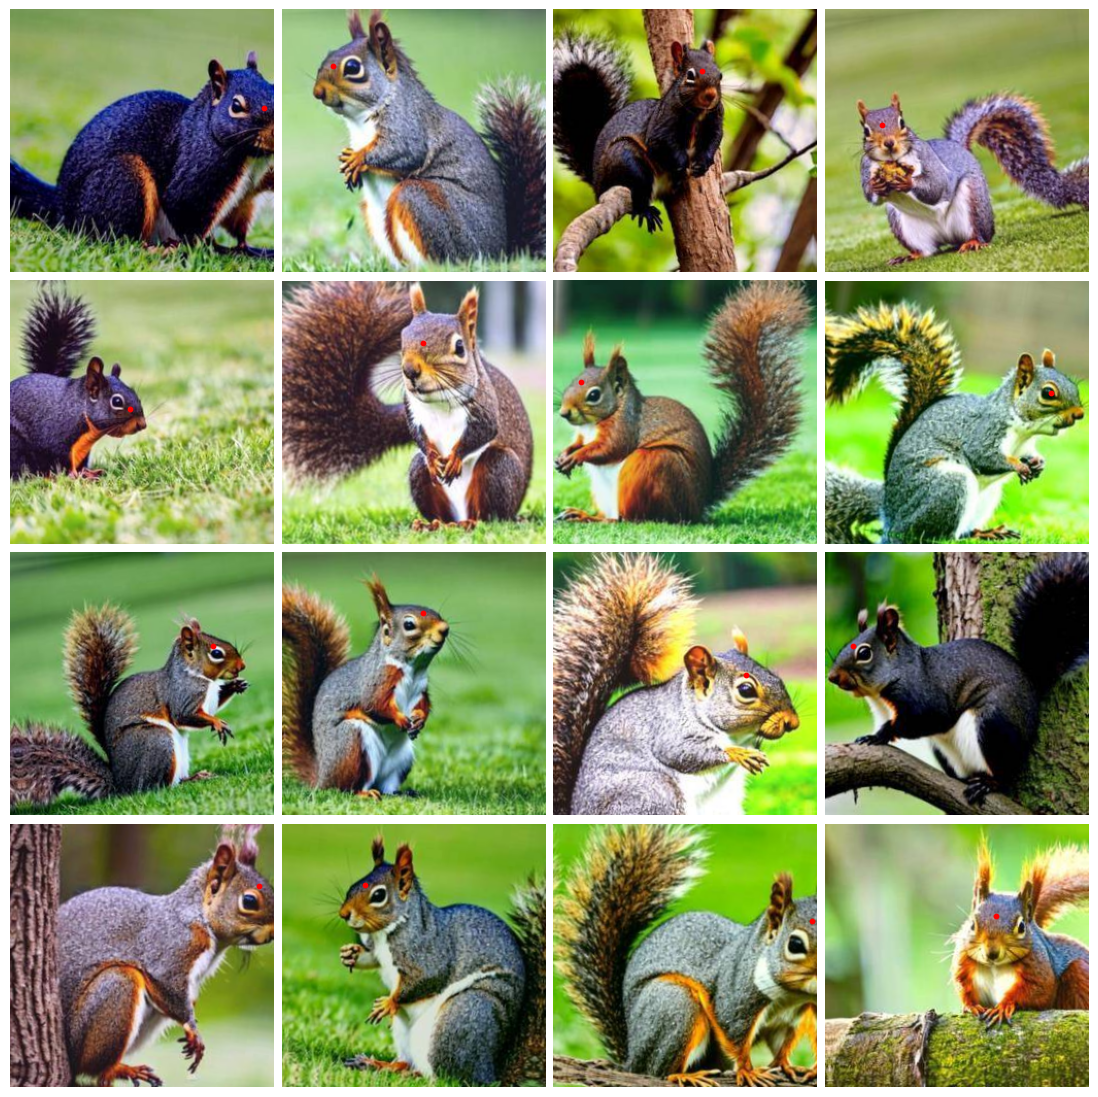

In [5]:
data = next(iterator)
visualize_batch(data[0]/255.0, data[2], size = 14, shape = (4, 4), title = 'Check Dataset and augmentation', save = False)

### Проверка правильности предсказаний на белочках

In [6]:
dataframe = pd.read_pickle(train_df_path)
train_df, valid_df = train_test_split(dataframe, test_size=0.25, random_state=42)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ])

dataset = KeypointDataset(
        valid_df, 
        transform, 
        image_height=image_height, 
        image_width=image_width)

data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=num_workers)

mean_relative_distance = MeanRelativeDistance(image_width=image_width, image_height=image_height)
mean_accuracy = MeanAccuracy(image_width=image_width, image_height=image_height, treashold=treashold)

weight_path = test_weights
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = MobileKeypointNet().to(device)
model_wrapper = ModelWrapper(model=model)
model_wrapper.load(path_to_model=weight_path)

In [7]:
keypoints_pred = model_wrapper.predict(predict_data_loader=data_loader, device=device)
mrd = mean_relative_distance(torch.tensor(keypoints_pred), torch.tensor(valid_df['keypoints'], dtype=torch.float32))
ma = mean_accuracy(torch.tensor(keypoints_pred), torch.tensor(valid_df['keypoints'], dtype=torch.float32))

print(f'mean_relative_distance: {mrd}')
print(f'mean_accuracy: {ma}')

/home/dima/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


mean_relative_distance: 0.06423164159059525
mean_accuracy: 0.8618742823600769


/tmp/ipykernel_172495/620953272.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  mrd = mean_relative_distance(torch.tensor(keypoints_pred), torch.tensor(valid_df['keypoints'], dtype=torch.float32))


In [8]:
valid_df['keypoints_pred'] = list(keypoints_pred)

In [9]:
valid_df.head()

image_paths   keypoints  \
0  ./data/the_center_of_the_teddy_bear_nose/fda23...   [90, 152]   
1  ./data/the_center_of_the_teddy_bear_nose/fcf89...   [128, 70]   
2  ./data/the_center_of_the_koalas_nose/74e4c1c0f...   [146, 60]   
3  ./data/the_center_of_the_teddy_bear_nose/80c0d...   [95, 100]   
4  ./data/the_center_of_the_owls_head/e7f3d080b7f...  [120, 131]   

   dataset_idxs          keypoints_pred  
0             6   [96.49646, 164.62167]  
1             6   [133.50934, 75.09374]  
2             3   [154.75122, 67.48554]  
3             6   [95.672585, 99.67733]  
4             4  [129.49203, 129.02261]

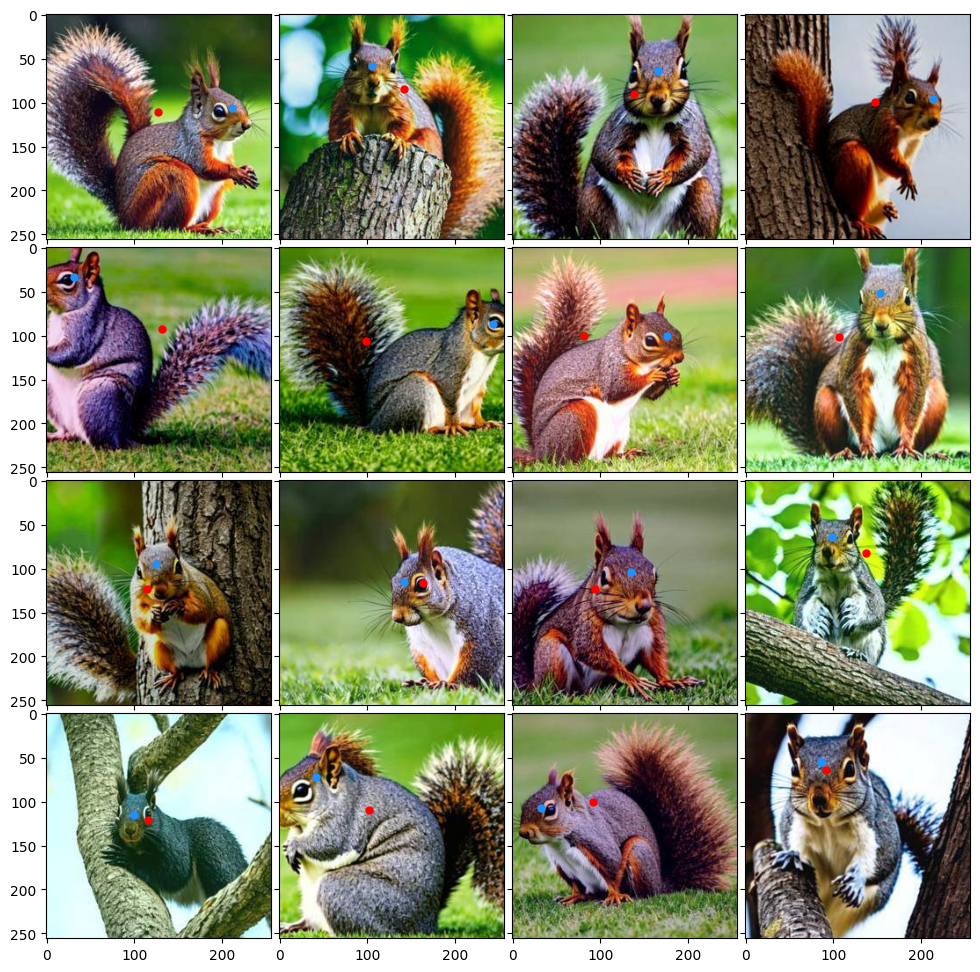

In [10]:
visualize_errors(dataframe=valid_df[valid_df['dataset_idxs'] == 0], max_images=16, size=3, n_cols=4)

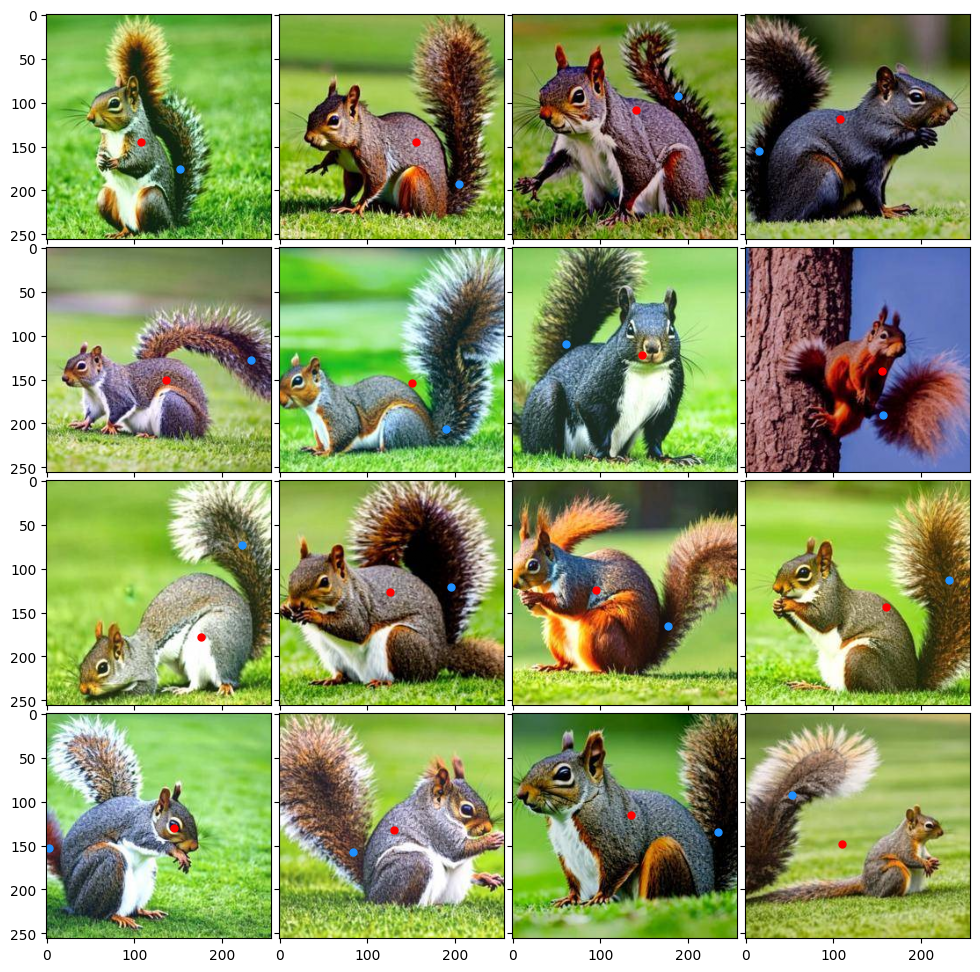

In [11]:
visualize_errors(dataframe=valid_df[valid_df['dataset_idxs'] == 1], max_images=16, size=3, n_cols=4)

In [1]:
import pandas as pd

In [2]:
qwe = pd.read_pickle('./train_dataframe.pkl')

In [3]:
qwe

image_paths   keypoints  \
0             ./data/squirrels_head/bf9f9e2f372bf940.jpg   [72, 183]   
1             ./data/squirrels_head/13f513d688810fde.jpg    [87, 71]   
2             ./data/squirrels_head/fff3f33b2923a107.jpg    [85, 74]   
3             ./data/squirrels_head/8a88bd7d26eedcc0.jpg   [104, 60]   
4             ./data/squirrels_head/10101e16d897e0ff.jpg  [192, 148]   
...                                                  ...         ...   
21251  ./data/the_center_of_the_teddy_bear_nose/7f203...   [142, 98]   
21252  ./data/the_center_of_the_teddy_bear_nose/30fdf...  [162, 101]   
21253  ./data/the_center_of_the_teddy_bear_nose/f7e7d...   [157, 44]   
21254  ./data/the_center_of_the_teddy_bear_nose/efd1e...  [137, 102]   
21255  ./data/the_center_of_the_teddy_bear_nose/4797e...   [175, 67]   

       dataset_idxs  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
21251             6  
21252             6  
21253             6  
21254             6  
21255             6  

[21256 rows x 3 columns]

In [1]:
qwe = {'a': 1, 'b': 2, 'c': 3}

In [2]:
len(qwe)

3

In [4]:
qwe['d']

KeyError: 'd'